In [37]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree, cophenet
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox 

In [38]:
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [39]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


In [41]:
df.drop(['Region', 'Channel'], axis=1, inplace=True)

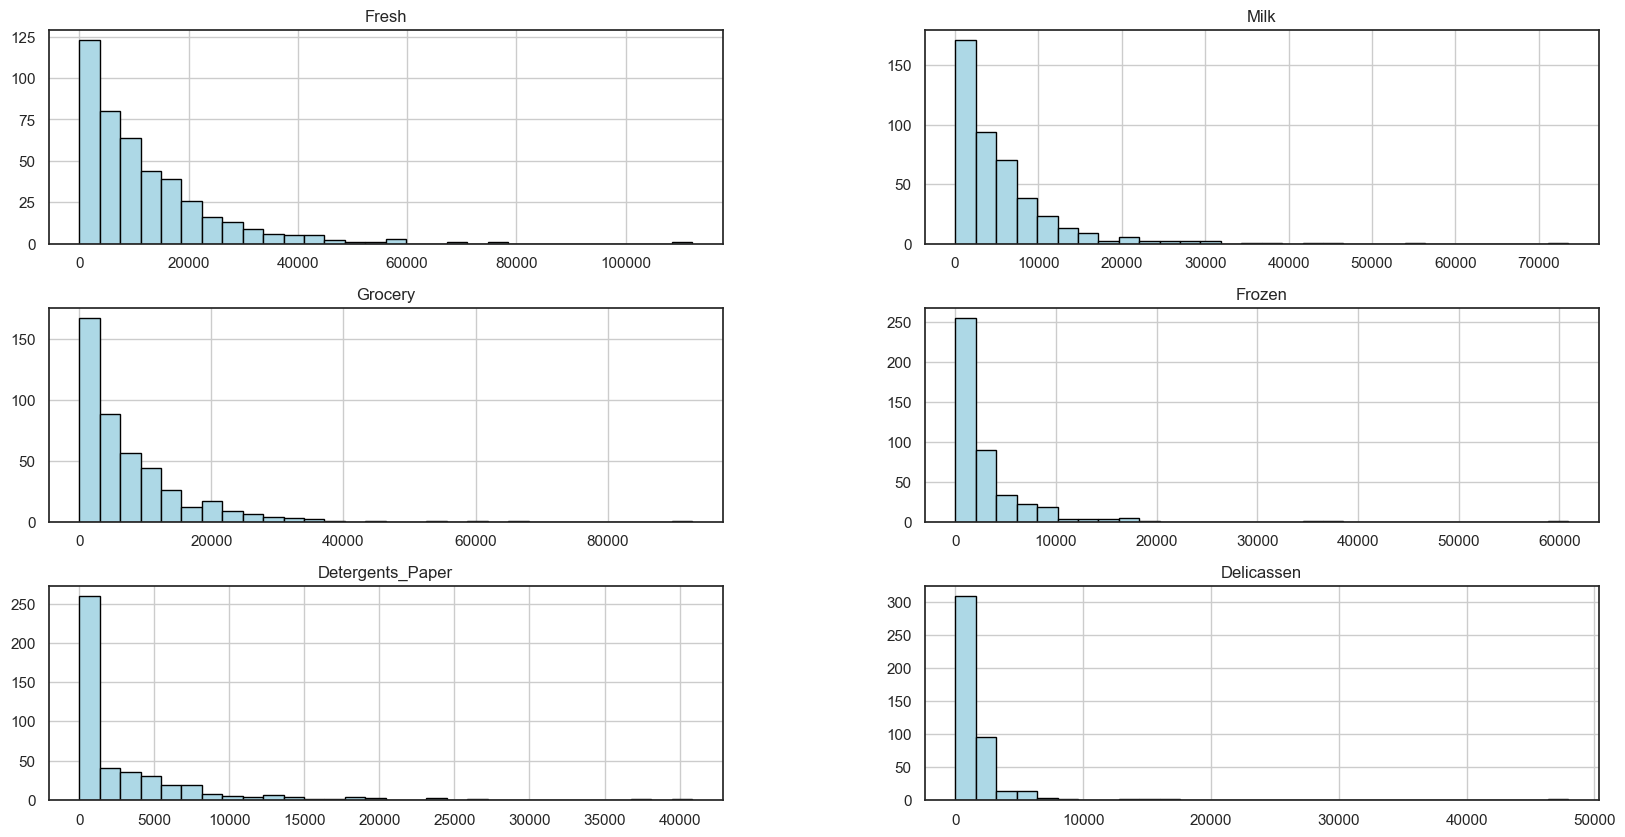

In [42]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

In [43]:
skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Variable', 'Shapiro Test', 'Skewness Coefficient', 'Skewness', 'Kurtosis Coefficient', 'Kurtosis']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    normal_dist = 'Yes' if p >= 0.05 else 'No'
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Highly skewed' if skewness[col] < -1 or skewness[col] > 1 else 'Symmetric or mildly skewed'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Very flat or sharp' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal or mildly flat'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Yes' if p_sh >= 0.05 else 'No'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|     Variable     | Shapiro Test | Skewness Coefficient |   Skewness    | Kurtosis Coefficient |      Kurtosis      |
+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|      Fresh       |      No      |        2.5613        | Highly skewed |       11.5364        | Very flat or sharp |
|       Milk       |      No      |        4.0538        | Highly skewed |       24.6694        | Very flat or sharp |
|     Grocery      |      No      |        3.5874        | Highly skewed |       20.9147        | Very flat or sharp |
|      Frozen      |      No      |        5.9080        | Highly skewed |       54.6893        | Very flat or sharp |
| Detergents_Paper |      No      |        3.6319        | Highly skewed |       19.0095        | Very flat or sharp |
|    Delicassen    |      No      |       11.151

In [44]:
normality=pd.DataFrame(index=['p-value', 'test-statistic'])
for i in df.columns:
    normality[i]=shapiro(df[i])
    
normality.T

,p-value,test-statistic
Fresh,0.781436,7.918344e-24
Milk,0.628334,9.762267e-30
Grocery,0.676230,3.906112e-28
Frozen,0.528297,1.291356e-32
Detergents_Paper,0.605482,1.914582e-30
Delicassen,0.361068,1.753416e-36


In [45]:
df = np.log(df)

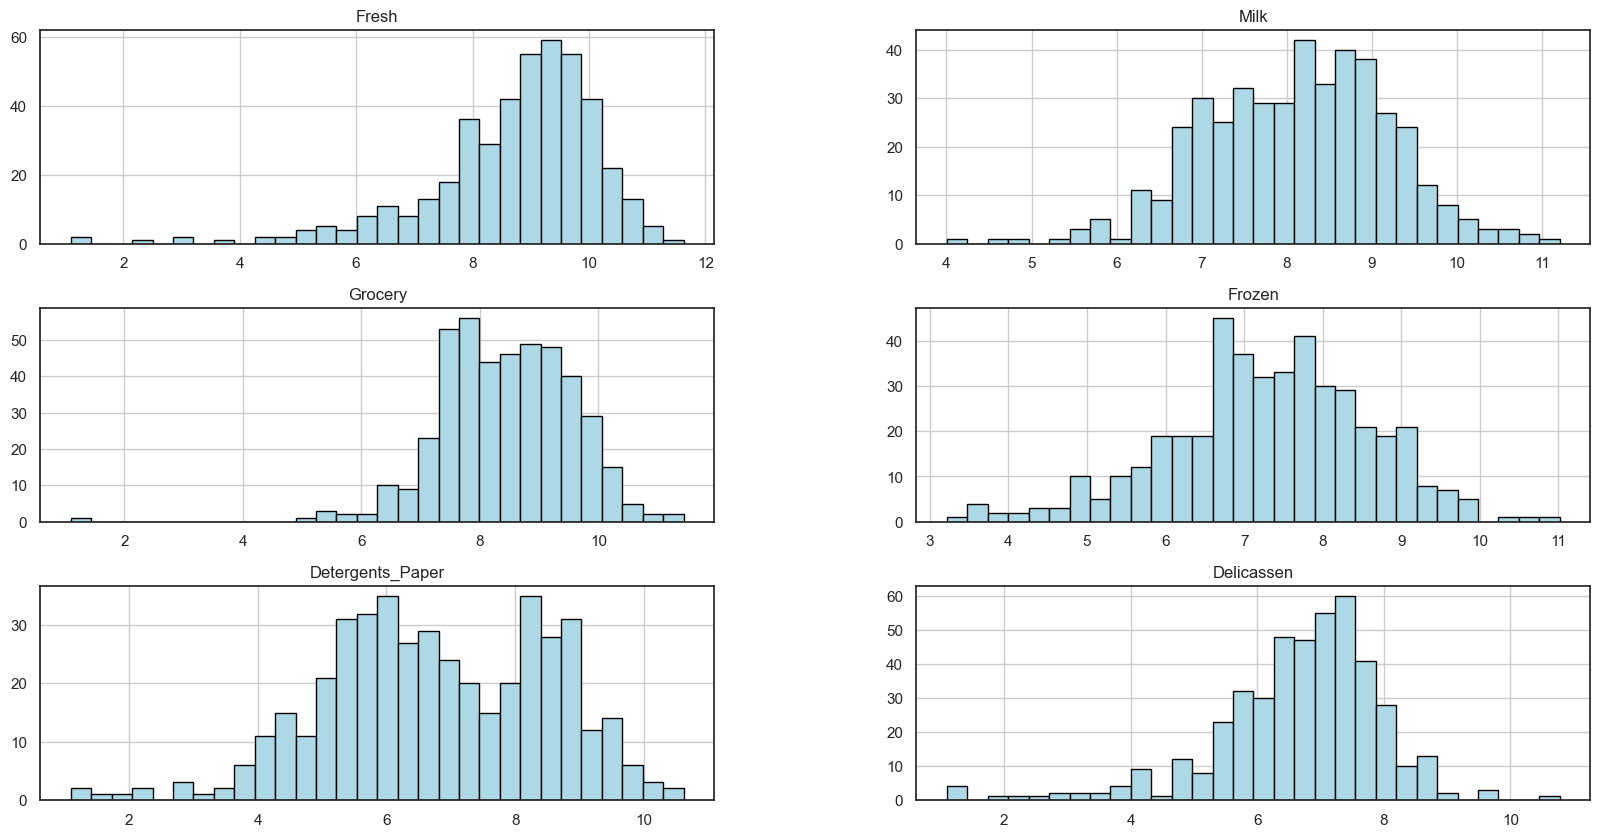

In [46]:
df.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

<Axes: >

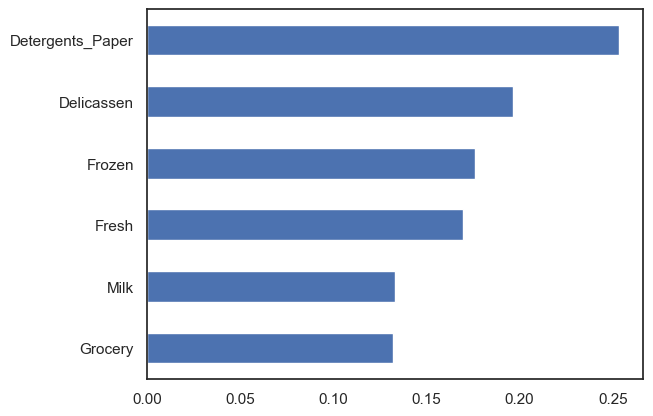

In [48]:
variability_coefficient = df.std() / df.mean()
sorted_vc = variability_coefficient.sort_values()
sorted_vc.plot.barh(x='Variables', y='Variability Coefficient')

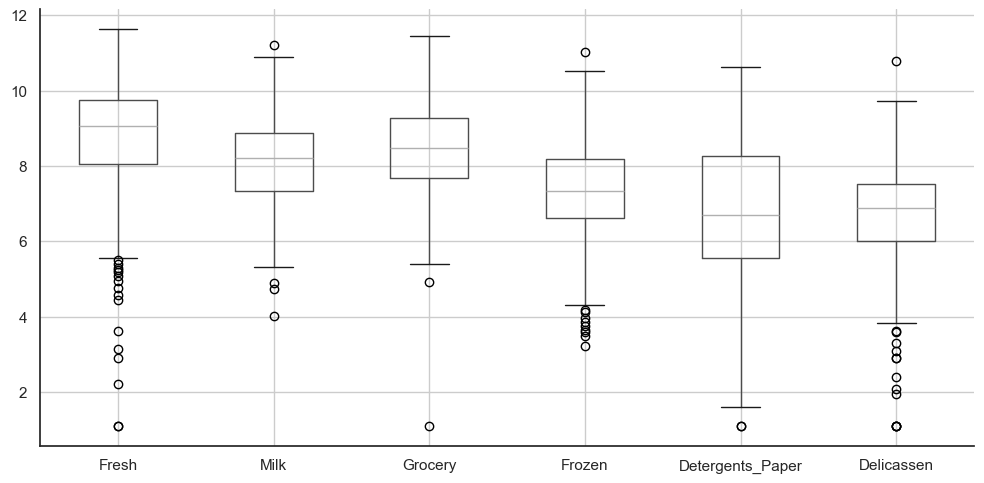

In [49]:
plt.figure(figsize=(10, 5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

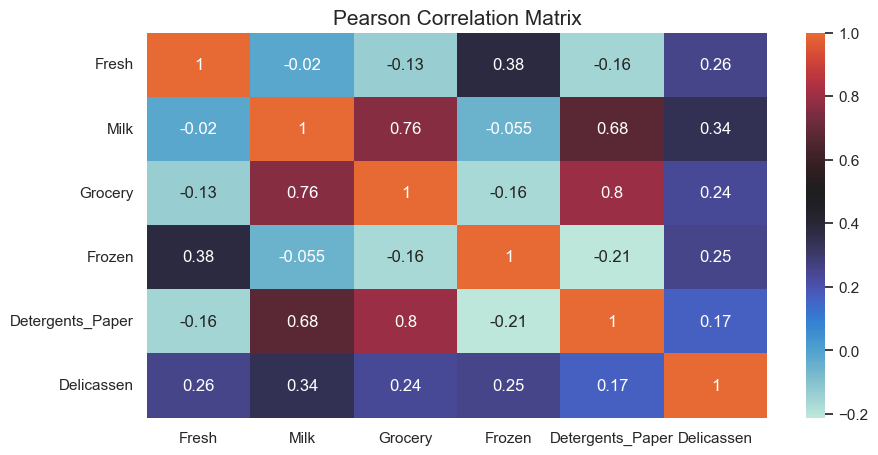

In [50]:
corr=df.corr()
plt.figure(figsize=(10,5))
plt.title('Pearson Correlation Matrix',fontsize=15)
sns.heatmap(corr, center=0.5,annot=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

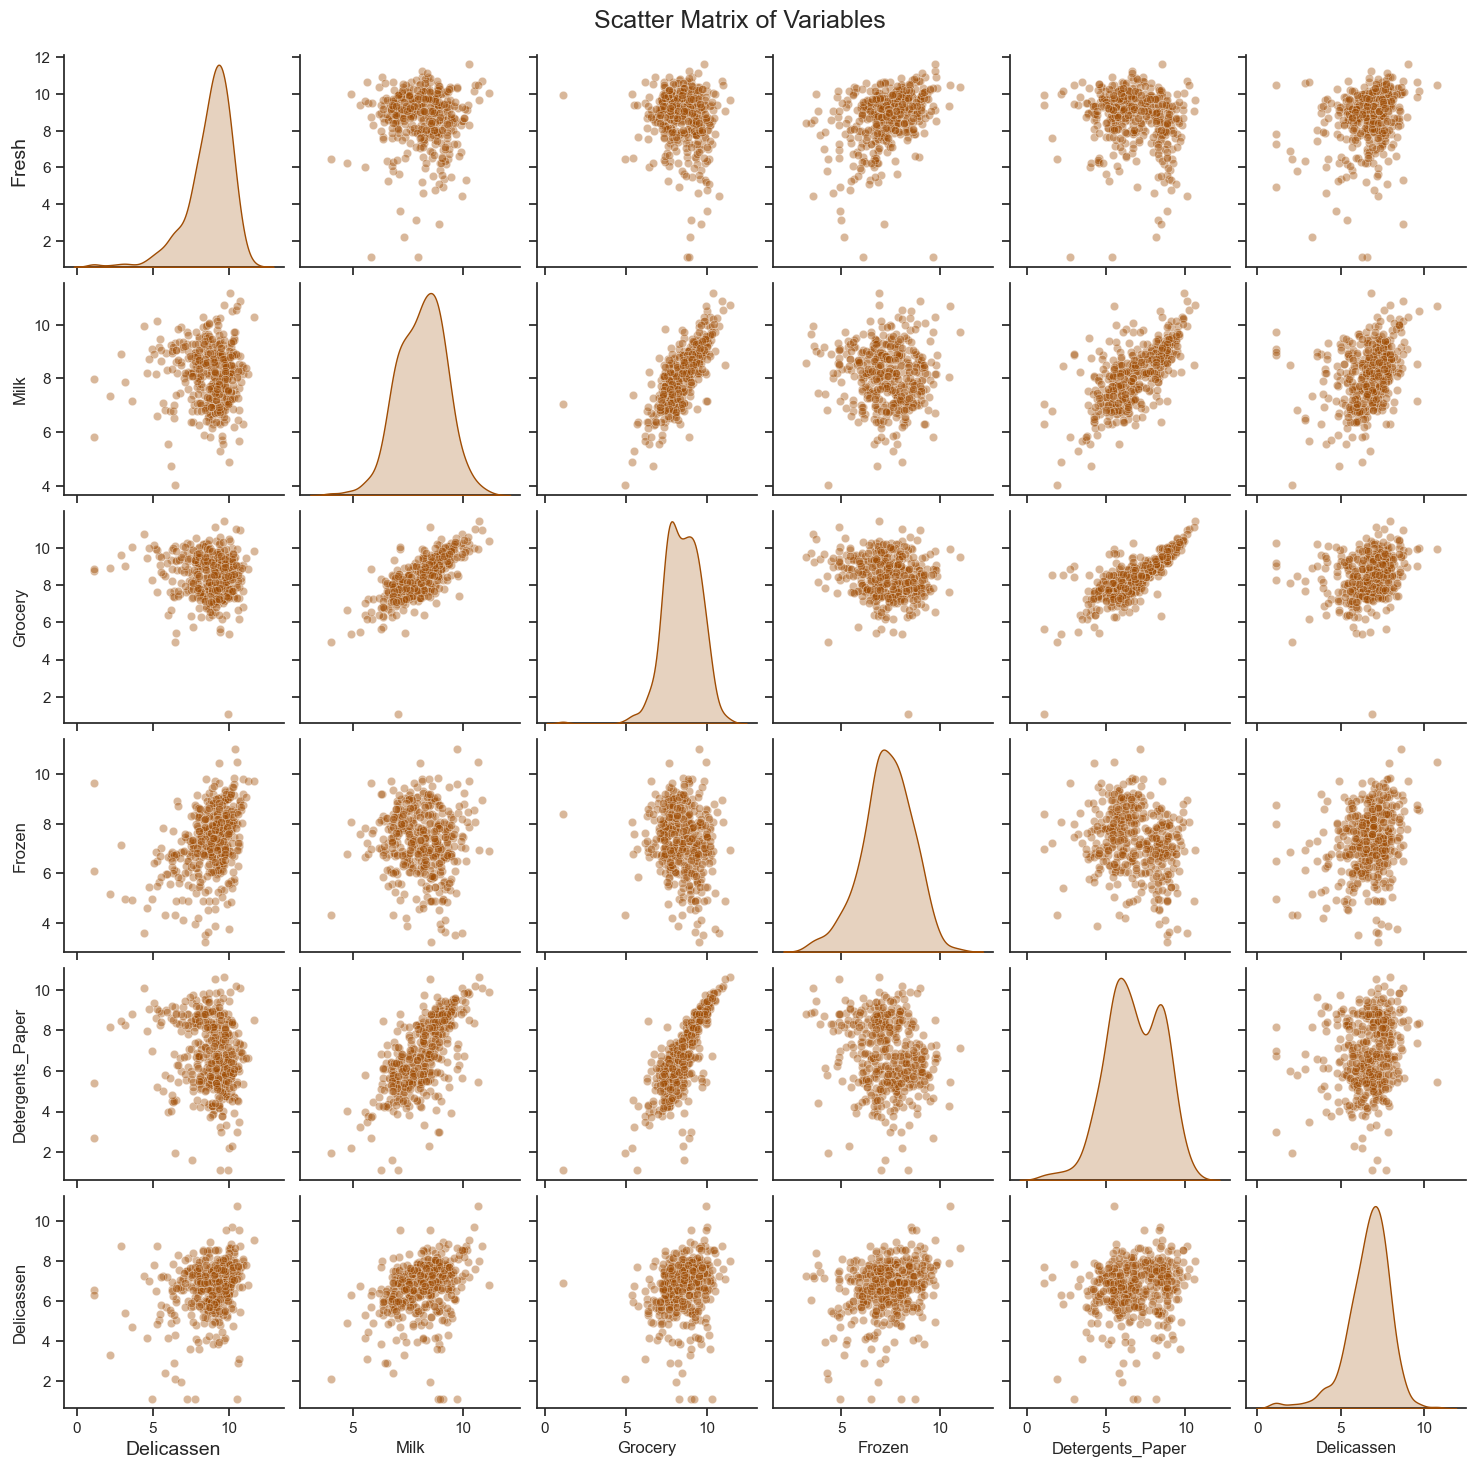

In [51]:
custom_palette = sns.color_palette(["#9f4c03"])
sns.set(style='ticks', palette=custom_palette) 
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha': 0.4})
plt.subplots_adjust(top=0.95)  
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)  
scatter_matrix.axes[0, 0].set_ylabel(df.columns[0], fontsize=14)  
scatter_matrix.axes[-1, 0].set_xlabel(df.columns[-1], fontsize=14)  
plt.show()

Выбросы

In [52]:
# Словарь для хранения выбросов
outliers = {}

for col in df.columns:
    # 25-й и 75-й процентиль
    q25, q75 = np.percentile(df[col], [25, 75])
    iqr = q75 - q25
    
    # Границы выбросов
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    
    # Выборка выбросов
    outlier_values = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    # Добавление в словарь, если есть выбросы
    if not outlier_values.empty:
        outliers[col] = outlier_values.values

# Выводим результаты
for col, values in outliers.items():
    print(f'{col} ({len(values)} выбросов): {values}')


Fresh (16 выбросов): [4.44265126 2.19722458 5.38907173 1.09861229 3.13549422 4.94164242
 5.29831737 5.19295685 2.89037176 5.08140436 5.49306144 1.09861229
 4.76217393 5.24702407 3.61091791 4.57471098]
Milk (4 выбросов): [11.20501347  4.71849887  4.00733319  4.8978398 ]
Grocery (2 выбросов): [1.09861229 4.91998093]
Frozen (10 выбросов): [ 3.49650756  3.63758616  3.58351894  3.73766962  3.95124372  4.11087386
 11.01647929  3.21887582  3.8501476   4.17438727]
Detergents_Paper (2 выбросов): [1.09861229 1.09861229]
Delicassen (14 выбросов): [ 3.29583687  1.09861229  1.09861229  3.58351894  1.09861229  2.07944154
 10.77776808  2.39789527  1.09861229  2.89037176  1.94591015  2.89037176
  3.09104245  3.61091791]


In [53]:
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25,75])
    iqr = q75 - q25
    
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    
    df.loc[df[i] < lower_bound, i] = lower_bound
    df.loc[df[i] > upper_bound, i] = upper_bound

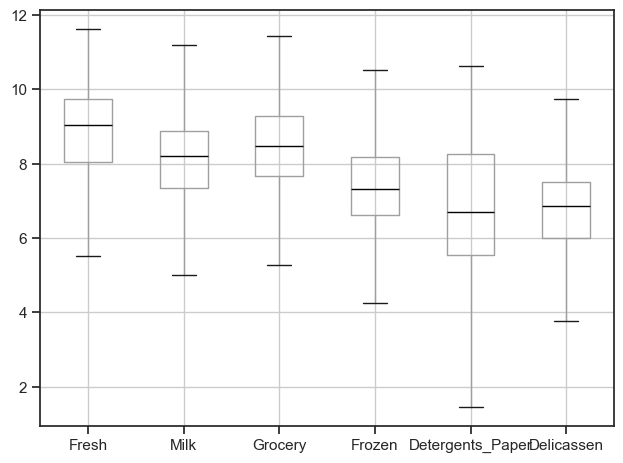

In [54]:
df.boxplot()
plt.tight_layout()
plt.show()

Пропуски и дубликаты

In [55]:
df.isnull().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [56]:
df.duplicated().sum()

np.int64(0)

Стандартизация

In [57]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [58]:
euclidean_distances = pdist(df, metric='euclidean')
cluster_hierarchy = linkage(euclidean_distances, method='average')
coph_corr, coph_dist = cophenet(cluster_hierarchy, euclidean_distances)
observation_names = np.arange(0, df.shape[0]).tolist()

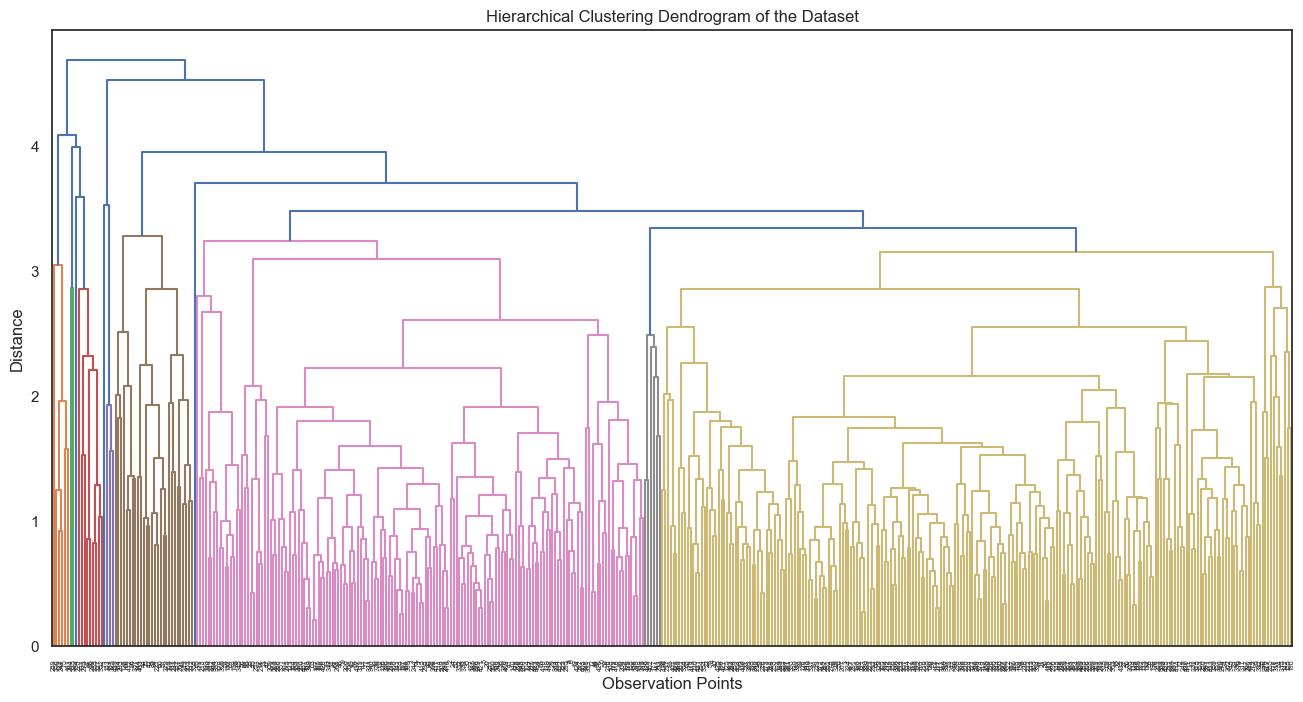

In [59]:
sns.set()
sns.set_style('white')
plt.figure(figsize=(16, 8))
dendrogram(cluster_hierarchy, labels=observation_names)
plt.title('Hierarchical Clustering Dendrogram of the Dataset')
plt.xlabel('Observation Points')
plt.ylabel('Distance')
plt.show()

In [60]:
print(f'Cophenetic Correlation Coefficient: {coph_corr}')

Cophenetic Correlation Coefficient: 0.6448497671919403



K-Means

In [61]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df)
labels = kmeans.labels_

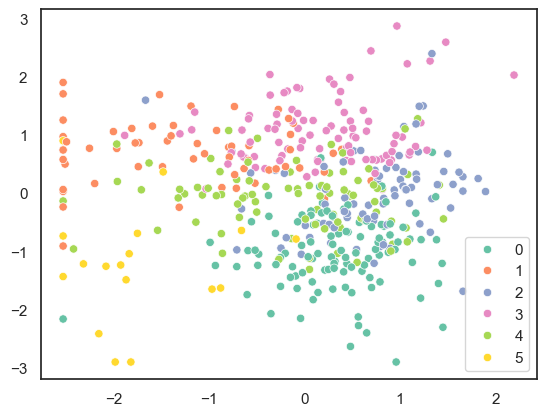

In [62]:
sns.scatterplot(x=df[:, 0], y=df[:, 1], hue=labels, palette='Set2')
plt.show()

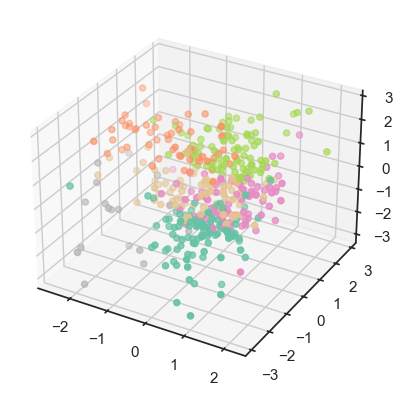

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=labels, cmap='Set2')
plt.show()

DBSCAN

In [64]:
dbscan = DBSCAN(eps=1)
dbscan.fit(df)
labels_dbscan = dbscan.labels_

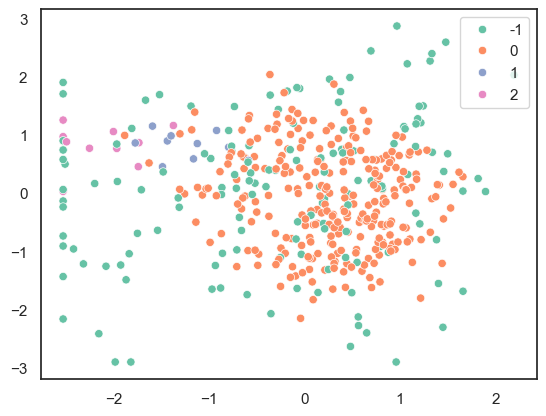

In [65]:
sns.scatterplot(x=df[:, 0], y=df[:, 1], hue=labels_dbscan, palette='Set2')
plt.show()